* Algo for using simulation to solve for strategy
* Compare analytical and numerical strategy

In [12]:
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [13]:
def cardsToIndex(player_hand, dealer_card, draw = None):
    index_scaling = [10**11, 10**10, 10**9, 10**8, 10**7, 10**6, 10**5, 10**4, 10**2, 10**0]
    index = 10000000000000 + dealer_card*10**12
    player_hand[10 - draw] += 1 if draw != None else player_hand
    for card in range(10):
        index += index_scaling[card] * player_hand[card]
    return index

In [14]:
def indexToCards(index):#TODO
    index = list(str(index)[1:])
    dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    dealer_hand[9 - int(index[0])] += 1
    index = index[1:]
    return [int(x) for x in index[0:-4] + [index[-4] + index[-3]] + [index[-2] + index[-1]]], dealer_hand

In [15]:
def score(player_cards):
    score = player_cards[-1] * 11
    high_aces = player_cards[-1]
    for cardIndex in range(9):
        score += (10 - cardIndex) * player_cards[cardIndex]
    #Determine whether to use aces as 1 or 11
    while score > 21 and high_aces > 0:
        if high_aces > 0:
            score -= 10
            high_aces -= 1
    return score 

In [16]:
def winner(player_score, dealer_score):
    if player_score < 22:
        if player_score > dealer_score:
            return 0
        if player_score < dealer_score and dealer_score < 22:
            return 1
        if dealer_score > 21:
            return 0
        if player_score == dealer_score:
            return 2
    else:
        return 1

In [17]:
def deckContents(position):
    return np.array([x - y for x, y in zip([card*position.decks for card in [16, 4, 4, 4, 4, 4, 4, 4, 4, 4]], position.cards_in_play)])

In [18]:
class Position:
    def __init__(self, index = None, cards = None, dealer_card = None, draw = None, decks = 1):
        self.dealer_face = dict(zip(range(0,10), [1, 10, 2, 3, 4, 5, 6, 7, 8, 9]))[dealer_card]
        if index != None:
            self.index = index
            self.player_hand, self.dealer_hand = indexToCards(self.index)
        if index == None:
            self.player_hand = cards
            self.dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            self.dealer_hand[10 - self.dealer_face] += 1
            self.index = cardsToIndex(self.player_hand, dealer_card, draw)
        self.hand_size = len(self.player_hand)
        self.score = score(self.player_hand)
        self.bust = True if self.score > 21 else False
        self.decks = decks
        self.parents = []
        self.hit_return = 0
        

        self.cards_in_play = [x + y for x, y in zip(self.player_hand, self.dealer_hand)]

        self.valid = True if all(x < 4*self.decks + 1  for x in self.cards_in_play[1:]) and self.cards_in_play[0] < 16*self.decks + 1 else False

    def get_numerical_stick_probability(self, simulations):
        outcomes = [0, 0, 0]
        player_wins, dealer_wins, ties = 0, 0, 0
        dealer_card = self.dealer_face
        player_score = self.score
        draw_weights = np.array([x - y for x, y in zip([card*self.decks for card in [16, 4, 4, 4, 4, 4, 4, 4, 4, 4]], self.cards_in_play)])
        base_weights = []
        for i in range(10):
            base_weights += [10 - i]*draw_weights[i]

        base_dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        base_dealer_hand[10 - dealer_card] += 1

        while simulations > 0:
            temp_weights = base_weights.copy()
            dealer_hand = base_dealer_hand.copy()
            dealer_score = 0
            while dealer_score < 17:
                card = temp_weights.pop(rn.randint(0, len(temp_weights) - 1))
                dealer_hand[10 - card] += 1
                dealer_score = score(dealer_hand)
            outcomes[winner(player_score, dealer_score)] += 1

            simulations -= 1 
        self.numerical_stick_probability = (outcomes[0] - outcomes[1])/sum(outcomes)

    def get_analytic_stick_probability(self):
        deck_contents = deckContents(self)
        total_cards_in_deck = sum(deck_contents)
        Master = {}
        Next = {"".join(map(str, self.dealer_hand)): [self.dealer_hand, 1]}
        Depth = 0
        while len(Next) != 0:
            Current = Next.copy()
            Next = {}
            for hand_index in Current.keys():
                for drawn_card in range(1,11):
                    hand = Current[hand_index][0].copy()
                    comparison = hand.copy()#Improve this and next two lines :/
                    comparison[10 - self.dealer_face] -= 1
                    if comparison[10 - drawn_card] < deck_contents[10 - drawn_card]:
                        next_index_cards = hand.copy()
                        next_index_cards[10 - drawn_card] += 1
                        next_index = "".join(map(str, next_index_cards))
                        next_score = score(next_index_cards)
                        hand[10 - self.dealer_face] -= 1
                        if next_score < 17:
                            if next_index not in Next.keys():
                                Next[next_index] = [next_index_cards, 0]
                            Next[next_index][1] += Current[hand_index][1] * (deck_contents[10 - drawn_card] - hand[10 - drawn_card])/(total_cards_in_deck - Depth)
                        else:
                            if next_index not in Master.keys():
                                Master[next_index] = [0, next_score]
                            Master[next_index][0] += Current[hand_index][1] * (deck_contents[10 - drawn_card] - hand[10 - drawn_card])/(total_cards_in_deck - Depth)
            Depth += 1

        count = [0,0,0]
        score_outcomes = {}
        player_score = self.score
        for possible_dealer_score in range(17, 27):
            score_outcomes[possible_dealer_score] = winner(player_score, possible_dealer_score)
        for check in Master.keys():
            count[score_outcomes[Master[check][1]]] += Master[check][0]

        self.analytic_stick_probability = (count[0] - count[1])/sum(count)

    def get_error(self):
        self.error = self.analytic_stick_probability - self.numerical_stick_probability

    def set_hit_return(self, hit_return):
        self.hit_return = hit_return

In [19]:
class Strategy:
    def __init__(self, decks = 1):
        self.decks = decks

    def get_positions(self):
        Next = {10000000000000 : Position(index = 10000000000000, dealer_card = 1)}
        self.positions = {}
        runs = 0
        while len(Next) != 0:
            Current = Next.copy()
            Next = {}
            for position in Current.values():
                for drawn in range(1, 11):
                    gate = True
                    for dealer_card in range(0, 10):
                        temp = position.player_hand.copy()
                        current_position = Position(cards = temp, draw = drawn, dealer_card = dealer_card, decks = self.decks)
                        if not current_position.bust and current_position.valid:
                            if gate:
                                Next[current_position.index] = current_position
                                gate = False
                            if runs > 0:
                                self.positions[current_position.index] = current_position
            runs += 1
    
    def get_numerical_stick_probability(self, simulations):
        for position in self.positions.values():
            position.get_numerical_stick_probability(simulations)
    
    def get_analytic_stick_probability(self):
        for position in self.positions.values():
            position.get_analytic_stick_probability()

    def get_error(self):
        for position in self.positions.values():
            position.get_error()       

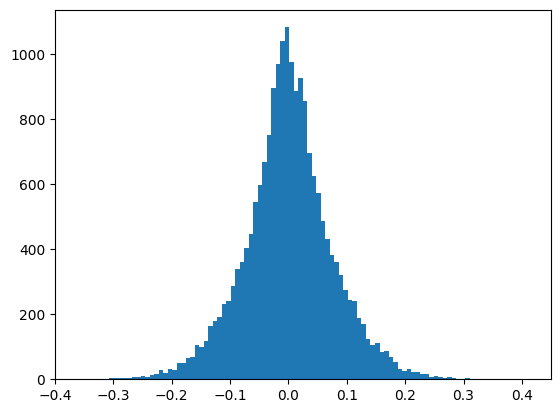

7.889978387349165e-05

In [20]:
strategy = Strategy()
strategy.get_positions()
strategy.get_numerical_stick_probability(100)
strategy.get_analytic_stick_probability()
strategy.get_error()
#We expect the difference between Monte Carlo derived and anlytically derived probabilities 
#to follow a Gaussian distribution with mean 0 and sd proportional to inv sqrt number of simulations
errors = [position.error for position in strategy.positions.values()]
plt.hist(errors, bins = 100)
plt.show()
np.mean(errors)

Obtain optimal strategy
* Start at top
* Go through stick, hit
* Choose optimal. Log as property. Go next. 
* When size 2, include surrender and double down. Maybe add double down always. 

In [21]:
for position in reversed(strategy.positions.values()):#Reverse so we start with largest hands and work down
    hit_return = 0
    for drawable_card in range(0,10):
        current_index = cardsToIndex(position.player_hand, position.dealer_face, draw = drawable_card + 1)
        p = position.cards_in_play[9 - drawable_card]/(52 * position.decks - sum(position.cards_in_play))
        daughter_stick_return = strategy.positions[current_index].self.analytic_stick_probability if current_index in strategy.positions else -1
        hit_return += p * daughter_stick_return
    strategy.positions[position.index].set_hit_return(hit_return)

In [22]:
vars(position)

{'dealer_face': 1,
 'player_hand': [1, 1, 1, 1, 1, 1, 1, 1, 1, 3],
 'dealer_hand': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'index': 10000000000002,
 'hand_size': 10,
 'score': 12,
 'bust': False,
 'decks': 1,
 'parents': [],
 'expected_return': -0.00510204081632653,
 'cards_in_play': [0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
 'valid': True,
 'numerical_stick_probability': -0.84,
 'analytic_stick_probability': -0.7731363901853265,
 'error': 0.06686360981467343}